In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import json
import pprint
import seaborn as sns
import numpy as np
import random
from time import time
import pickle

In [2]:
from pymongo import MongoClient
from stop_words import get_stop_words
from nltk.stem import WordNetLemmatizer
import gensim
from gensim import corpora, models
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [3]:
def SaveDict(filename, mode, root):
    if filename[-4:]!=".txt":
        filename+=".txt"
    with open(filename, mode) as f:
        f.write(pprint.pformat(root))

def LoadDict(filename):
    if filename[-4:]!=".txt":
        filename+=".txt"
    with open(filename, "r") as f:
        return eval(f.read())

In [4]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [5]:
client = MongoClient()
db = client.twitter

In [ ]:
texts = []
for article in db.articles.find():
    doc = article['text']

    doc = doc.replace("\n"," ")
    doc = doc.replace("\'","")

    doc = gensim.utils.simple_preprocess(doc)

    wordnet_lemmatizer = WordNetLemmatizer()
    doc = [wordnet_lemmatizer.lemmatize(word) for word in doc]
    doc = [wordnet_lemmatizer.lemmatize(word,pos='v') for word in doc]

    en_stop = get_stop_words('en')
    letters = ["a","b","c","d","e","f","g","h","i","j","k","l","m","n","o","p","q","r","s","t","u","v","w","x","y","z"]
    other = ["wa","ha","one","two","id","re","http","com","mr","image","photo","caption","don","sen","pic","co",
             "source","watch","play","duration","video","momentjs","getty","images","newsletter", "story", "go", "like", "say",
             "will", "just", "today", "can", "year", "make", "view", "read"]
    doc = [word for word in doc if not word in (en_stop+letters+other)]
    db.articles.update_one({"_id": article["_id"]}, {"$set": {"clean_text": doc}})
    texts.append(doc)

In [ ]:
random.seed(42)
train_set = random.sample(list(range(0,len(texts))),len(texts)-1000)
test_set = [x for x in list(range(0,len(texts))) if x not in train_set]

train_texts = [texts[i] for i in train_set]
test_texts = [texts[i] for i in test_set]

pickle.dump([train_set,test_set,train_texts,test_texts],open('./data/pub_articles_train_test_sets.pkl','wb'))

In [170]:
train_Set, test_set, train_texts, test_texts = pickle.load(open('./data/pub_articles_train_test_sets.pkl','rb'))

## tf-idf + LDA

In [ ]:
topicnums = [1,5,10,15,20,30,40,50,60,70,80,90,100]

dictionary = corpora.Dictionary(train_texts)
corpus = [dictionary.doc2bow(text) for text in train_texts]
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
print corpus_tfidf

ldamodels_tfidf = {}
for i in topicnums:
    random.seed(42)
    %time ldamodels_tfidf[i] = models.ldamodel.LdaModel(corpus_tfidf,num_topics=i,id2word=dictionary)
    ldamodels_tfidf[i].save('./data/ldamodels_tfidf_'+str(i)+'.lda')

In [ ]:
# http://radimrehurek.com/topic_modeling_tutorial/2%20-%20Topic%20Modeling.html
def intra_inter_tfidf(lda_model, dictionary, test_docs, num_pairs=10000):
    
    # Split each test document into two halves and compute topics for each half
    part1 = [lda_model[tfidf[dictionary.doc2bow(tokens[:int(len(tokens)/2)])]] for tokens in test_docs]
    part2 = [lda_model[tfidf[dictionary.doc2bow(tokens[int(len(tokens)/2):])]] for tokens in test_docs]   
    
    # Compute topic distribution similarities using cosine similarity
    
    #print("Average cosine similarity between corresponding parts (higher is better):")
    corresp_parts = np.mean([gensim.matutils.cossim(p1, p2) for p1, p2 in zip(part1, part2)])

    #print("Average cosine similarity between 10,000 random parts (lower is better):")    
    random.seed(42)
    random_pairs = np.random.randint(0, len(test_docs), size=(num_pairs, 2))
    random_parts = np.mean([gensim.matutils.cossim(part1[i[0]], part2[i[1]]) for i in random_pairs])
    
    return corresp_parts, random_parts

In [ ]:
topicnums = [1,5,10,15,20,30,40,50,60,70,80,90,100]
ldamodels_eval = {}
for i in topicnums:
    lda_model = models.ldamodel.LdaModel.load('./data/ldamodels_tfidf_'+str(i)+'.lda')
    ldamodels_eval[i] = intra_inter_tfidf(lda_model, dictionary, test_texts)
    
pickle.dump(ldamodels_eval,open('./data/pub_ldamodels_tfidf_eval.pkl','wb'))

In [ ]:
topicnums = [1,5,10,15,20,30,40,50,60,70,80,90,100]

ldamodels_eval = pickle.load(open('./data/pub_ldamodels_tfidf_eval.pkl','rb'))
corresp_parts = [ldamodels_eval[i][0] for i in topicnums]
random_parts = [ldamodels_eval[i][1] for i in topicnums]
sns.set_context("poster")
with sns.axes_style("darkgrid"):
    x = topicnums
    y1 = corresp_parts
    y2 = random_parts
    plt.plot(x,y1,label='Parts from same article')
    plt.plot(x,y2,label='Parts from random articles')
    plt.ylim([0.0,1.0])
    plt.xlabel('Number of topics')
    plt.ylabel('Average cosine similarity')    
    plt.legend()    
    plt.show()

In [ ]:
topicnums = [1,5,10,15,20,30,40,50,60,70,80,90,100]

lda_topics = {}
for i in topicnums:
    lda_model = models.ldamodel.LdaModel.load('./data/ldamodels_tfidf_'+str(i)+'.lda')
    lda_topics_string = lda_model.show_topics(i)
    lda_topics[i] = ["".join([c if c.isalpha() else " " for c in topic[1]]).split() for topic in lda_topics_string]

pickle.dump(lda_topics,open('./data/pub_lda_tfidf_topics.pkl','wb'))

In [ ]:
def jaccard_similarity(query, document):
    intersection = set(query).intersection(set(document))
    union = set(query).union(set(document))
    return float(len(intersection))/float(len(union))

In [ ]:
lda_stability = {}
for i in range(0,len(topicnums)-1):
    jacc_sims = []
    for t1,topic1 in enumerate(lda_topics[topicnums[i]]):
        sims = []
        for t2,topic2 in enumerate(lda_topics[topicnums[i+1]]):
            sims.append(jaccard_similarity(topic1,topic2))    
        jacc_sims.append(sims)    
    lda_stability[topicnums[i]] = jacc_sims
    
pickle.dump(lda_stability,open('./data/pub_lda_tfidf_stability.pkl','wb'))

In [ ]:
topicnums = [1,5,10,20,30,40,50,60,70,80,90,100]

lda_stability = pickle.load(open('./data/pub_lda_tfidf_stability.pkl','rb'))
mean_stability = [np.array(lda_stability[i]).mean() for i in topicnums[:-1]]

with sns.axes_style("darkgrid"):
    x = topicnums[:-1]
    y = mean_stability
    plt.plot(x,y,label='Mean overlap')
    plt.xlim([1, 100])
    plt.ylim([0, 1])
    plt.xlabel('Number of topics')
    plt.ylabel('Average Jaccard similarity')    
    #plt.legend()    
    plt.show()

## Bag of Words + LDA

In [191]:
topicnums = [1,5,10,15,20,30,40,50,60,70,80,90,100]

dictionary = corpora.Dictionary(train_texts)
pickle.dump(dictionary,open('./data/pub_ldamodels_bow_dictionary.pkl','wb'))

In [ ]:
corpus = [dictionary.doc2bow(text) for text in train_texts]

ldamodels_bow = {}
for i in topicnums:
    random.seed(42)
    %time ldamodels_bow[i] = models.ldamodel.LdaModel(corpus,num_topics=i,id2word=dictionary)
    ldamodels_bow[i].save('./data/ldamodels_bow_'+str(i)+'.lda')

In [172]:
# http://radimrehurek.com/topic_modeling_tutorial/2%20-%20Topic%20Modeling.html
def intra_inter_bow(lda_model, dictionary, test_docs, num_pairs=10000):
    
    # Split each test document into two halves and compute topics for each half
    part1 = [lda_model[dictionary.doc2bow(tokens[:int(len(tokens)/2)])] for tokens in test_docs]
    part2 = [lda_model[dictionary.doc2bow(tokens[int(len(tokens)/2):])] for tokens in test_docs]   
    
    # Compute topic distribution similarities using cosine similarity
    
    #print("Average cosine similarity between corresponding parts (higher is better):")
    corresp_parts = np.mean([gensim.matutils.cossim(p1, p2) for p1, p2 in zip(part1, part2)])

    #print("Average cosine similarity between 10,000 random parts (lower is better):")    
    random.seed(42)
    random_pairs = np.random.randint(0, len(test_docs), size=(num_pairs, 2))
    random_parts = np.mean([gensim.matutils.cossim(part1[i[0]], part2[i[1]]) for i in random_pairs])
    
    return corresp_parts, random_parts

In [173]:
ldamodels_eval = {}
for i in topicnums:
    lda_model = models.ldamodel.LdaModel.load('./data/ldamodels_bow_'+str(i)+'.lda')
    ldamodels_eval[i] = intra_inter_bow(lda_model, dictionary, test_texts)
    
pickle.dump(ldamodels_eval,open('./data/pub_ldamodels_bow_eval.pkl','wb'))

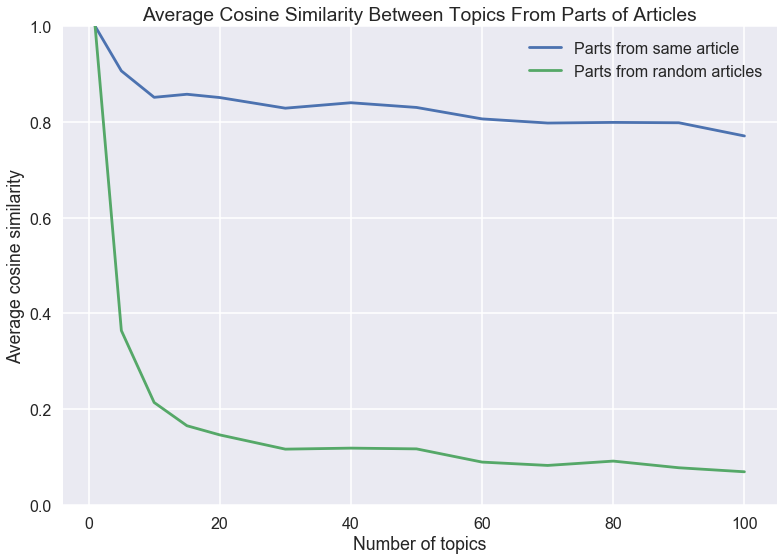

In [68]:
topicnums = [1,5,10,15,20,30,40,50,60,70,80,90,100]

ldamodels_eval = pickle.load(open('./data/pub_ldamodels_bow_eval.pkl','rb'))
corresp_parts = [ldamodels_eval[i][0] for i in topicnums]
random_parts = [ldamodels_eval[i][1] for i in topicnums]
sns.set_context("poster")
with sns.axes_style("darkgrid"):
    x = topicnums
    y1 = corresp_parts
    y2 = random_parts
    plt.plot(x,y1,label='Parts from same article')
    plt.plot(x,y2,label='Parts from random articles')
    plt.ylim([0.0,1.0])
    plt.xlabel('Number of topics')
    plt.ylabel('Average cosine similarity') 
    plt.title('Average Cosine Similarity Between Topics From Parts of Articles')
    plt.legend()    
    plt.show()

In [175]:
topicnums = [1,5,10,15,20,30,40,50,60,70,80,90,100]

lda_topics = {}
for i in topicnums:
    lda_model = models.ldamodel.LdaModel.load('./data/ldamodels_bow_'+str(i)+'.lda')
    lda_topics_string = lda_model.show_topics(i)
    lda_topics[i] = ["".join([c if c.isalpha() else " " for c in topic[1]]).split() for topic in lda_topics_string]

pickle.dump(lda_topics,open('./data/pub_lda_bow_topics.pkl','wb'))

In [176]:
lda_stability = {}
for i in range(0,len(topicnums)-1):
    jacc_sims = []
    for t1,topic1 in enumerate(lda_topics[topicnums[i]]):
        sims = []
        for t2,topic2 in enumerate(lda_topics[topicnums[i+1]]):
            sims.append(jaccard_similarity(topic1,topic2))    
        jacc_sims.append(sims)    
    lda_stability[topicnums[i]] = jacc_sims
    
pickle.dump(lda_stability,open('./data/pub_lda_bow_stability.pkl','wb'))

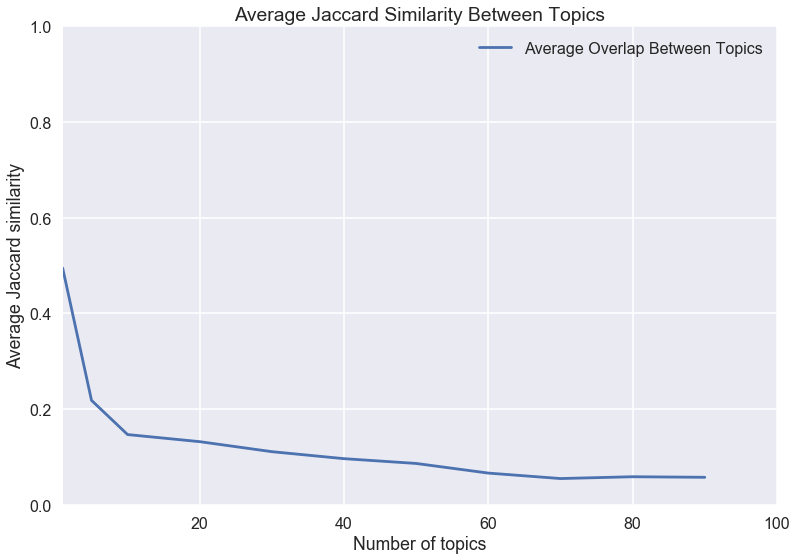

In [67]:
topicnums = [1,5,10,20,30,40,50,60,70,80,90,100]

lda_stability = pickle.load(open('./data/pub_lda_bow_stability.pkl','rb'))
mean_stability = [np.array(lda_stability[i]).mean() for i in topicnums[:-1]]

with sns.axes_style("darkgrid"):
    x = topicnums[:-1]
    y = mean_stability
    plt.plot(x,y,label='Average Overlap Between Topics')
    plt.xlim([1, 100])
    plt.ylim([0, 1])
    plt.xlabel('Number of topics')
    plt.ylabel('Average Jaccard similarity')   
    plt.title('Average Jaccard Similarity Between Topics')
    plt.legend()    
    plt.show()

## Optimal Model

In [6]:
num_topics = 20
lda_model = models.ldamodel.LdaModel.load('./data/ldamodels_bow_'+str(num_topics)+'.lda')
doc_dict = pickle.load(open('./data/pub_ldamodels_bow_dictionary.pkl','rb'))

In [195]:
lda_topics = lda_model.show_topics(num_topics)
lda_topics_words = ["".join([c if c.isalpha() else " " for c in topic[1]]).split() for topic in lda_topics]
lda_topics_disp = [("topic "+str(i)+": ")+" ".join(topic) for i,topic in enumerate(lda_topics_words)]
lda_topics_disp
pickle.dump(lda_topics_disp,open('./data/pub_lda_bow_topics.pkl','wb'))

In [ ]:
article_topics = {}
retweet_count = {}
for i in range(num_topics):
    db.articles.update_many({}, {"$unset": {"topic "+str(i): ""}}, upsert=True)
for article in db.articles.find():
    doc = article["clean_text"]
    #doc_dict = gensim.corpora.Dictionary([doc])
    doc_corp = doc_dict.doc2bow(doc)

    doc_prob = lda_model[doc_corp]
    
    topic_prob = [0 for i in range(num_topics)]
    for prob in doc_prob:
        topic_prob[prob[0]] = prob[1] 
        
    article_topics[article["id"]] = topic_prob
    retweet_count[article["id"]] = db.posts.find_one({"id": article["id"]})["retweet_count"]
    
    for probs in doc_prob:
        db.articles.update_one({"_id": article["_id"]}, {"$set": {"topic "+str(probs[0]): probs[1]}})

### Group Topic Extration

In [ ]:
dictionary = pickle.load(open('./data/pub_ldamodels_bow_dictionary.pkl','rb'))
group_doc = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[]}
for article in db.articles.find():
    if "label" in article:
        group_doc[int(article["label"])] += article["clean_text"]

group_topics = {}
for i in group_doc.keys():
    doc_corp = dictionary.doc2bow(group_doc[i])
    doc_prob = lda_model[doc_corp]
    
    topic_prob = [0 for j in range(num_topics)]
    for prob in doc_prob:
        topic_prob[prob[0]] = prob[1]
    group_topics[i] = doc_prob

pickle.dump(group_topics, open('./data/group_lda_bow_topics.pkl','wb')) 

In [9]:
def to_full_vec(group_topics, num_topics):
    topic_vec = [0 for j in range(num_topics)]
    for prob in group_topics:
        topic_vec[prob[0]] = prob[1]
    return topic_vec

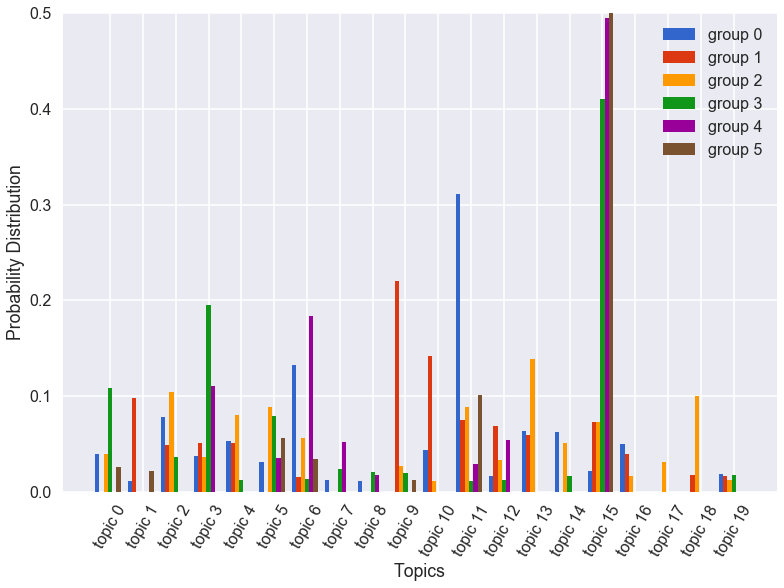

In [69]:
group_topics = pickle.load(open('./data/group_lda_bow_topics.pkl', 'rb'))

sns.set_context("poster")
fig, ax = plt.subplots()
width = 0.13
colors = ["#3366cc", "#dc3912", "#ff9900", "#109618", "#990099", "#7a5230"]
with sns.axes_style("darkgrid"):
    for i in range(6):
        position = [j+i*width for j in range(num_topics)]
        ax.bar(position, to_full_vec(group_topics[i], num_topics), width, label="group "+str(i), color=colors[i])
    plt.xlabel("Topics")
    plt.ylabel("Probability Distribution")
    position = [j+3*width for j in range(num_topics)]
    plt.xticks(position, ["topic "+str(i) for i in range(num_topics)], rotation=60)
    plt.ylim(0, 0.5)
    plt.legend()
    plt.show()

topic 15: trump comey president house investigation white russia fire director russian
topic 11: percent continue company market main advertisement bank new china time
topic 6: bloomberg data new business news time information company people financial
topic 3: trump state climate president budget change continue country unite paris


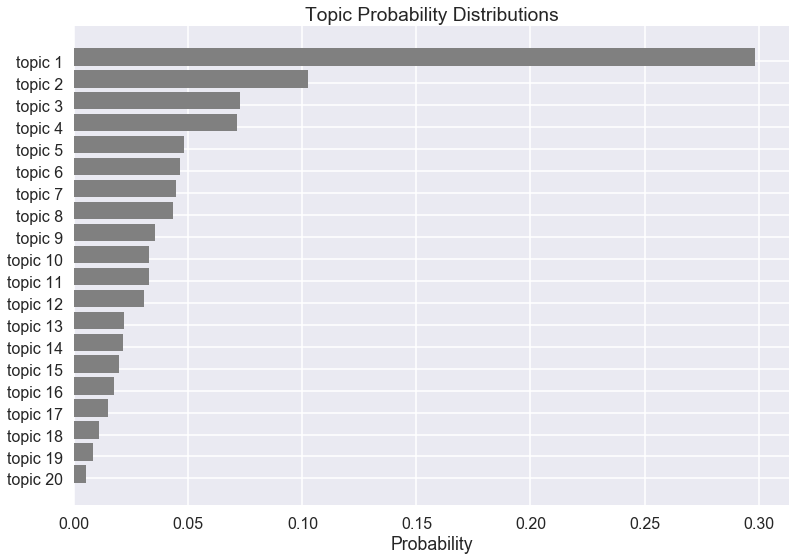

In [126]:
sns.set_context("poster")
topics = np.zeros(num_topics)
for i in range(6):
    topics += to_full_vec(group_topics[i], num_topics)
sorted_topics = -np.sort(-topics)
idx_sorted = np.argsort(-topics)
lda_topics = pickle.load(open('./data/pub_lda_bow_topics.pkl','rb'))
for i in range(4):
    print lda_topics[idx_sorted[i]]
plt.figure()
with sns.axes_style("darkgrid"):
    plt.barh(range(num_topics)[::-1], sorted_topics/6.0, color='grey')
    plt.xlabel("Probability")
    plt.yticks([i-0.2 for i in range(num_topics)], ["topic "+str(i+1) for i in range(num_topics)[::-1]])
    plt.title("Topic Probability Distributions")
    plt.legend()
    plt.show()

In [73]:
from collections import OrderedDict

import pandas as pd

from bokeh.plotting import figure, output_file, show
from bokeh.charts import Bar
from bokeh.io import output_notebook 

d_list = []
for j in range(6):
    for i in range(num_topics):
        d = {}
        d['group'] = j
        d['topic'] = i
        d['Probability'] = to_full_vec(group_topics[j], num_topics)[i]/6.0
        d_list.append(d)
df = pd.DataFrame(d_list)

output_notebook()

p = Bar(df, label='topic', values='Probability', stack='group', plot_width=900, plot_height=500, palette=colors)
show(p)

Loading BokehJS ...

[0.03874294327702537, 0.010639889390943798, 0.078225765332188002, 0.037139799051158405, 0.052945764939700962, 0.03074419953908071, 0.13257092345052149, 0.012397556029612074, 0.010736677435228542, 0, 0.042931423317678213, 0.31124156299533168, 0.016231246972906961, 0.063352243737119548, 0.061914168841395577, 0.021802665213730352, 0.050031018187442974, 0, 0, 0.018655198765390194]


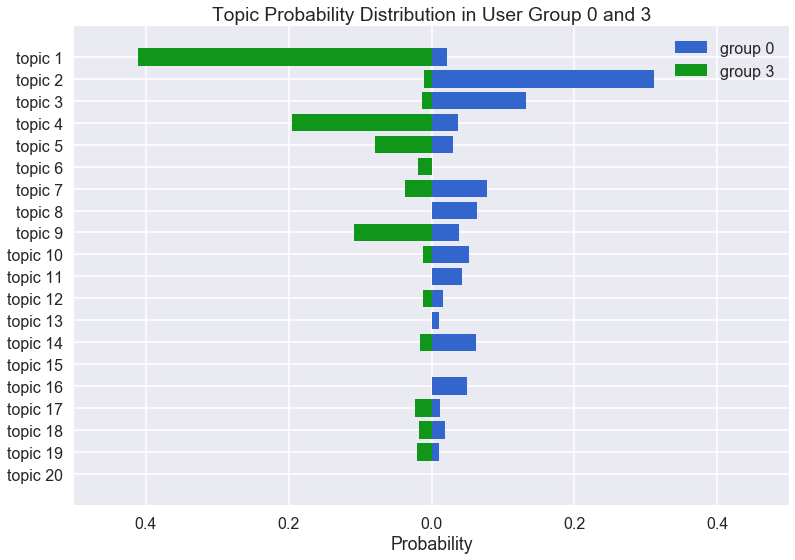

In [125]:
sns.set_context("poster")
plt.figure()
group = 0
topics = to_full_vec(group_topics[group], num_topics)
print topics
sorted_topics = np.zeros((2, num_topics))
for i in range(num_topics):
    sorted_topics[0, i] = topics[idx_sorted[i]]
    
group = 3
topics = to_full_vec(group_topics[group], num_topics)
for i in range(num_topics):
    sorted_topics[1, i] = topics[idx_sorted[i]]

sns.set_context("poster")
with sns.axes_style("darkgrid"):
    plt.barh(range(num_topics)[::-1], sorted_topics[0,:], label="group "+str(0), color=colors[0], align='center')
    plt.barh(range(num_topics)[::-1], -sorted_topics[1,:], label="group "+str(3), color=colors[3], align='center')
    plt.xlabel("Probability")
    plt.yticks([i for i in range(num_topics)], ["topic "+str(i+1) for i in range(num_topics)[::-1]])
    plt.xticks([-0.4,-0.2, 0.0, 0.2, 0.4], [0.4, 0.2, 0.0, 0.2, 0.4])
    plt.xlim(-0.5, 0.5)
    plt.title("Topic Probability Distribution in User Group 0 and 3")
    plt.legend()
    plt.show()

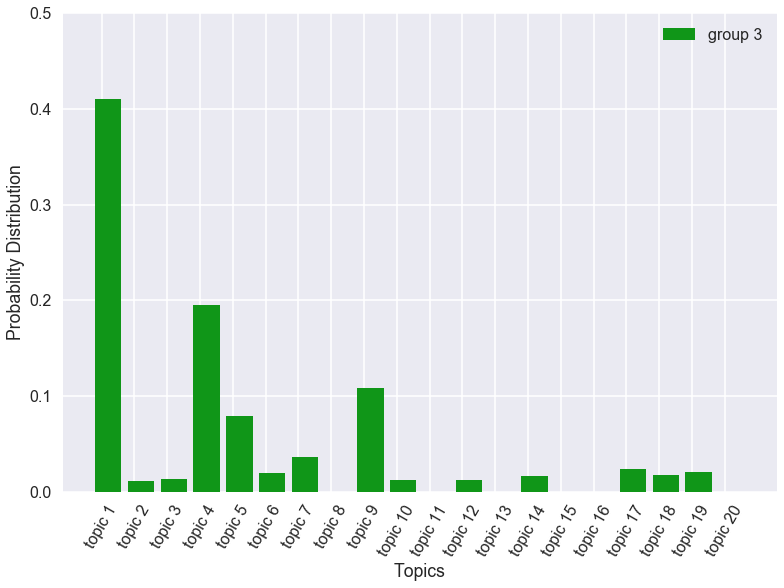

In [84]:
sns.set_context("poster")
plt.figure()
group = 3
topics = to_full_vec(group_topics[group], num_topics)
sorted_topics = np.zeros(num_topics)
for i in range(num_topics):
    sorted_topics[i] = topics[idx_sorted[i]]
with sns.axes_style("darkgrid"):
    plt.bar(range(num_topics), sorted_topics, width = 0.8, label="group "+str(group), color=colors[group])
    plt.xlabel("Topics")
    plt.ylabel("Probability Distribution")
    plt.xticks([i-0.2 for i in range(num_topics)], ["topic "+str(i+1) for i in range(num_topics)], rotation=60)
    plt.ylim(0, 0.5)
    plt.legend()
    plt.show()

In [76]:
lda_topics = pickle.load(open('./data/pub_lda_bow_topics.pkl','rb'))

In [56]:
for i in range(num_topics):
    print lda_topics[i]

topic 0: trump president saudi state first arabia house israel country washington
topic 1: main continue advertisement please time new receive error know people
topic 2: woman people show get tell time know first think life
topic 3: trump state climate president budget change continue country unite paris
topic 4: continue main advertisement city new get take time work call
topic 5: republican trump court election vote bill people democrat gianforte president
topic 6: bloomberg data new business news time information company people financial
topic 7: trump health republican president house bill care people continue tax
topic 8: location tweet trump twitter president add history learn always delete
topic 9: main advertisement continue trump time state president new please official
topic 10: continue time main trump new president advertisement free visit information
topic 11: percent continue company market main advertisement bank new china time
topic 12: continue main school student adve

In [65]:
group = 0
group_topics = pickle.load(open('./data/group_lda_bow_topics.pkl', 'rb'))
topic_vec = to_full_vec(group_topics[group], num_topics)
dict_words = {}
for i in range(num_topics):
    for word in lda_topics[i].split(":")[1].split(" "):
        if word in dict_words:
            dict_words[word] += topic_vec[i]
        else:
            dict_words[word] = topic_vec[i]    

91


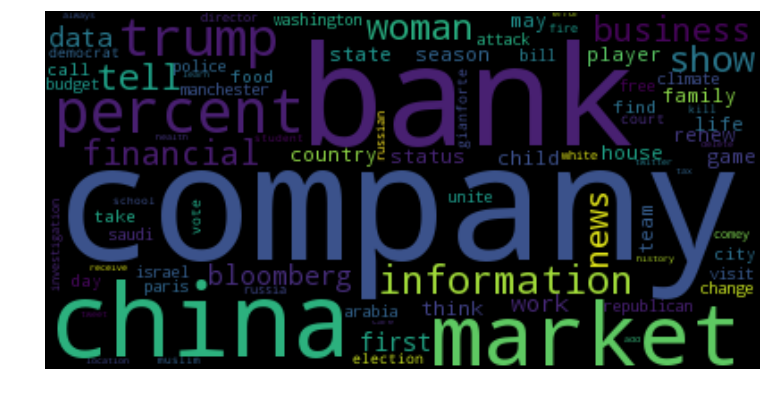

In [66]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
stopwords.add("new")
stopwords.add("time")
stopwords.add("main")
stopwords.add("continue")
stopwords.add("please")
stopwords.add("president")
stopwords.add("advertisement")
stopwords.add("know")
stopwords.add("people")

for word in stopwords:
    if word in dict_words:
        dict_words.pop(word, None)
print len(dict_words)

wordcloud = WordCloud(background_color="black")
wordcloud.generate_from_frequencies(frequencies=dict_words)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()